# Corpus Stats

In [1]:
# Allows for seamless use of updated src

%load_ext autoreload
%autoreload 2

# Switch to top of curiam directory for easier paths
%cd ../..


/Users/michael/dev/curiam


In [2]:
import statistics

from collections import Counter
from pathlib import Path

from curiam import categories
from curiam.preprocessing import inception_tsv

from matplotlib import pyplot as plt

## Data stats

### Table: total number of opinions and number of majority, concurring, and dissenting opinions

In [3]:
opinion_counts = {}

# These are plain text files that whose names have been standarized.
# TODO: Fix filenames in INCEpTION so exported filenames can be used directly
opinions_with_docket_numbers_dir = Path(
    "data/main/processed/inception_files_with_docket_numbers/")

for opinion_path in opinions_with_docket_numbers_dir.glob("*.txt"):
    # First 2 pieces make up docket number (e.g. 17_834), which we don't need
    _, _, opinion_type, author = opinion_path.name.split("_")
    # Reformat authors for displaying in table
    author = author[:-4]
    author = author[0].upper() + author[1:]
    if author not in opinion_counts.keys():
        opinion_counts[author] = Counter()
    opinion_counts[author][opinion_type] += 1

authors = sorted(opinion_counts.keys())
total = 0
majority_total = 0
concurrence_total = 0
dissent_total = 0
table_output = ""
for author in authors:
    # Calculate row sums and increment column totals
    majority = opinion_counts[author]["ootc"]
    majority_total += majority
    concurrence = opinion_counts[author]["concurrence"]
    concurrence_total += concurrence
    dissent = opinion_counts[author]["dissent"]
    dissent_total += dissent
    # Total for this particular justice
    justice_total = (majority + concurrence + dissent)
    total += justice_total
    table_output += f"{author} & {majority} & {concurrence} & {dissent} & {justice_total}\\\\\n"
table_output += "\\bottomrule\n"
table_output += f"& {majority_total} & {concurrence_total} & {dissent_total} & {total}\\\\"
output_path = Path("results/tables/opinion_characteristics.txt")
with output_path.open("w") as f:
    f.write(table_output)
print(f"Table saved to {output_path.as_posix()}")

Table saved to results/tables/opinion_characteristics.txt


In [4]:
opinions_dir = Path("data/main/annotated")
opinions = [inception_tsv.process_opinion_file(opinion_path, annotator="Michael")
            for opinion_path in sorted(opinions_dir.glob("*.tsv"), key= lambda path: path.name)]

assert len(opinions) == 41

In [5]:
sum_over = 0
threshold = 300
for opinion in opinions:
    for sentence in opinion:
        if len(sentence) > threshold:
            sum_over += 1
            print(sentence)

sum_over

['See', ',', 'e.g.', ',', 'Complaint', 'in', 'Hecox', ',', 'No', '.', '1', ':', '20', '-', 'CV-00184', '(', 'state', 'law', 'prohibiting', 'transgender', 'students', 'from', 'competing', 'in', 'school', 'sports', 'in', 'accordance', 'with', 'their', 'gender', 'identity', ')', ';', 'Second', 'Amended', 'Complaint', 'in', 'Karnoski', 'v.', 'Trump', ',', 'No', '.', '2:17', '-', 'cv-01297', '(', 'WD', 'Wash.', ',', 'July', '31', ',', '2019', ')', '(', 'military', "'s", 'ban', 'on', 'transgender', 'members', ')', ';', 'Kadel', 'v.', 'Folwell', ',', '----', 'F.', 'Supp', '.', '3d', '----', ',', '----', '-', '----', ',', '2020', 'WL', '1169271', ',', '*', '10-*11', '(', 'MDNC', ',', 'Mar.', '11', ',', '2020', ')', '(', 'state', 'health', 'plan', "'s", 'exclusion', 'of', 'coverage', 'for', 'sex', 'reassignment', 'procedures', ')', ';', 'Complaint', 'in', 'Gore', 'v.', 'Lee', ',', 'No', '.', '3:19', '-', 'cv-00328', '(', 'MD', 'Tenn.', ',', 'Mar.', '3', ',', '2020', ')', '(', 'change', 'of', 'g

1

In [8]:
print(opinions[0].sentences[0])

['Justice', 'GORSUCH', 'delivered', 'the', 'opinion', 'of', 'the', 'Court', '.']


### How many tokens are there?

In [9]:
token_total = sum([len(sentence) for opinion in opinions for sentence in opinion])
token_total

179690

### How many sentences are there?

In [11]:
sentence_total = sum([len(opinion) for opinion in opinions])
sentence_total

7068

## Annotation Stats

In [12]:
# All of the annotations in the corpus, grouped by sentence
all_annotations = [sentence.get_annotations(annotator="Michael")
               for opinion in opinions for sentence in opinion]

# Remove sentences which have 0 annotations, which will show as empty lists
all_annotations = [x for x in all_annotations if len(x) > 0]

# Annotations for the first sentence that has any annotations
all_annotations[0]

[Annotation(category='Metalinguistic Cue', start=8, end=8, annotator=''),
 Annotation(category='Definition', start=9, end=32, annotator=''),
 Annotation(category='Direct Quote', start=24, end=27, annotator=''),
 Annotation(category='Focal Term', start=25, end=26, annotator='')]

### How many annotations?

In [10]:
annotations_total = sum([len(sentence_annotations) for sentence_annotations in all_annotations])
annotations_total

9819

### How many sentences with at least one annotation?

In [11]:
sents_with_annotation = len(all_annotations)
print(f"{sents_with_annotation} ({(sents_with_annotation/sentence_total) * 100:.2f}%)")

4447 (62.92%)


### What percentage of tokens are covered by at least one annotation?

In [12]:
def get_token_coverage(sentence, annotation_column=2):
    return sum([1 if len(token[annotation_column]["categories"]) > 0
                else 0 for token in sentence])

coverage = sum([get_token_coverage(sentence, 2) for opinion in opinions for sentence in opinion])

print(f"Tokens annotated with at least one category: {coverage} ({(coverage/token_total) * 100:.2f}%)")


Tokens annotated with at least one category: 68715 (38.24%)


### Table: number of annotations for each category and their average length



In [13]:
category_freqs_and_lens = {}
for sentence_annotations in all_annotations:
    for annotated_span in sentence_annotations:
        category, start, end = [val for val in annotated_span]
        category_freqs_and_lens.setdefault(category, {"count": 0, "lengths": [] })
        category_freqs_and_lens[category]["count"] += 1
        category_freqs_and_lens[category]["lengths"].append((end - start) + 1)


In [14]:
table_output = ""
frequency_total = 0
for category in categories.ORDERED_CATEGORIES:
    frequency = category_freqs_and_lens[category]["count"]
    frequency_total += frequency
    mean = statistics.mean(category_freqs_and_lens[category]["lengths"])
    st_dev = statistics.stdev(category_freqs_and_lens[category]["lengths"])
    table_output += f"{category} & {frequency} & {mean:.1f}{'{'} ({st_dev:.1f}){'}'}\\\\\n"
table_output += "\\midrule\n"
table_output += f"Total & {frequency_total} &\\\\"
output_path = Path("results/tables/category_frequencies.txt")
with output_path.open("w", encoding="utf-8") as f:
    f.write(table_output)
print(f"Table saved to {output_path.as_posix()}")

Table saved to results/tables/category_frequencies.txt


### What percentage of annotations were direct quotes or legal sources?

In [15]:
dq_les_sum = category_freqs_and_lens["Direct Quote"]["count"] + category_freqs_and_lens["Legal Source"]["count"]
dq_les_percentage = (dq_les_sum / annotations_total) * 100
print(f"{dq_les_percentage:.2f}% of annotations were direct quotes or legal sources")

63.99% of annotations were direct quotes or legal sources


### Scatter plot opinion length vs coverage percemntage

In [16]:
from matplotlib import pyplot as plt

In [17]:
opinion_token_counts = []
opinion_annotation_counts = []
    
for opinion in opinions:
    opinion_token_count = 0
    opinion_annotation_count = 0
    for sentence in opinion:
        opinion_token_count += len(sentence)
        sentence_annotations = inception_tsv.get_sentence_annotations(sentence)
        opinion_annotation_count += len(sentence_annotations)
    opinion_token_counts.append(opinion_token_count)
    opinion_annotation_counts.append(opinion_annotation_count)

In [18]:
max(opinion_token_counts)

16658

In [19]:
import statistics

In [20]:
mean_tokens = statistics.mean(opinion_token_counts)
print(f"Mean of {mean_tokens:.0f} tokens per opinion")

Mean of 4383 tokens per opinion


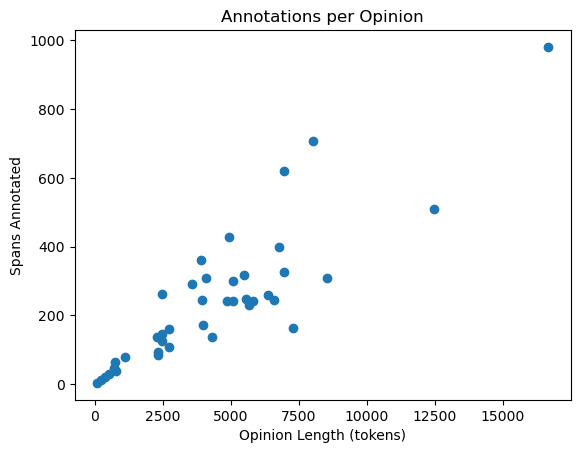

In [21]:
plt.scatter(opinion_token_counts, opinion_annotation_counts)
plt.title("Annotations per Opinion")
plt.xlabel("Opinion Length (tokens)")
plt.ylabel("Spans Annotated")
plt.savefig("results/figures/annotations_per_opinion.pdf")

In [22]:
metalinguistic_cue_set = set()
metalinguistic_cue_token_set = set()
for opinion in opinions:
    for sentence in opinion:
        sentence_annotations = inception_tsv.get_sentence_annotations(sentence)
        for annotation in sentence_annotations:
          category, start, end = [val for val in annotation]
          if category == "Metalinguistic Cue":
            span = ""
            for i in range(start, end + 1):
                span += " " + sentence[i][1].lower()
                metalinguistic_cue_token_set.add(sentence[i][1].lower())
            metalinguistic_cue_set.add(span.lstrip())

In [23]:
len(metalinguistic_cue_set)

416

In [24]:
len(metalinguistic_cue_token_set)

367

### Pie chart of opinion categories



In [25]:
frequencies = Counter()
for category in categories.ORDERED_CATEGORIES:
    frequency = category_freqs_and_lens[category]["count"]
    frequencies[category] += 1

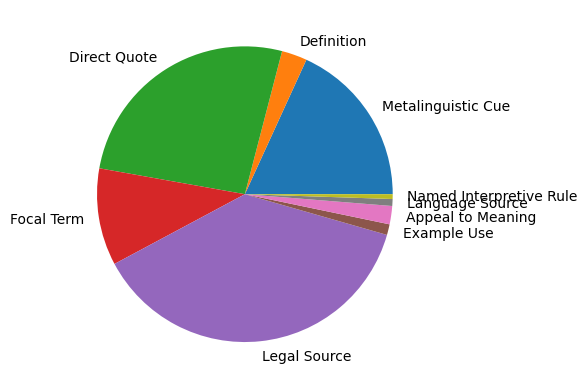

In [33]:
fig, ax = plt.subplots()
wedges, labels = ax.pie(x=[_["count"] for _ in category_freqs_and_lens.values()], labels = category_freqs_and_lens.keys())